## Introduction

In this notebook we will train a baseline multi-output regression model in Keras on the images to predict the 6 plant properties. The images are processed using the EfficientNet-B0 architectures, whose weights were pretrained on the ImageNet-1K dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras

from keras.applications.efficientnet import EfficientNetB0, preprocess_input

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pathlib import Path

plt.style.use('ggplot')
plt.rcParams.update(**{'figure.dpi':150})

2024-04-29 03:15:54.161893: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 03:15:54.161993: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 03:15:54.306198: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading the data

In [2]:
path = Path('/kaggle/input/planttraits2024/')
imgs_train = path / 'train_images'
imgs_test = path / 'test_images'

train = pd.read_csv(path / 'train.csv')
train['img_path'] = train['id'].apply(lambda x: imgs_train / f'{x}.jpeg')

test = pd.read_csv(path / 'test.csv')
test['img_path'] = test['id'].apply(lambda x: imgs_test / f'{x}.jpeg')

In [3]:
# targets
target_desc = pd.read_table(path / 'target_name_meta.tsv', sep='\t')
targets = target_desc['trait_ID'].tolist()
for row in target_desc.iterrows():
    print(row[1].tolist())

['X4', 'Stem specific density (SSD) or wood density (stem dry mass per stem fresh volume) ']
['X11', 'Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA) ']
['X18', 'Plant height ']
['X26', 'Seed dry mass ']
['X50', 'Leaf nitrogen (N) content per leaf area ']
['X3112', 'Leaf area (in case of compound leaves: leaf, undefined if petiole in- or excluded) ']


In [4]:
target_cols = [f'{col}_mean' for col in targets]
target_cols

['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']

## Target Preprocessing

In [5]:
X = train['img_path'].astype(str).values
Y = train[target_cols]

In [6]:
# remove bad observations
upper_quantiles = Y.quantile(0.98)
retained_flag = (Y < upper_quantiles).all(axis= 1) & (Y > 0).all(axis=1)
X = X[retained_flag]
Y = Y[retained_flag]

print(f'Number of observations removed: {retained_flag.shape[0] - retained_flag.sum()}')

Number of observations removed: 5691


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

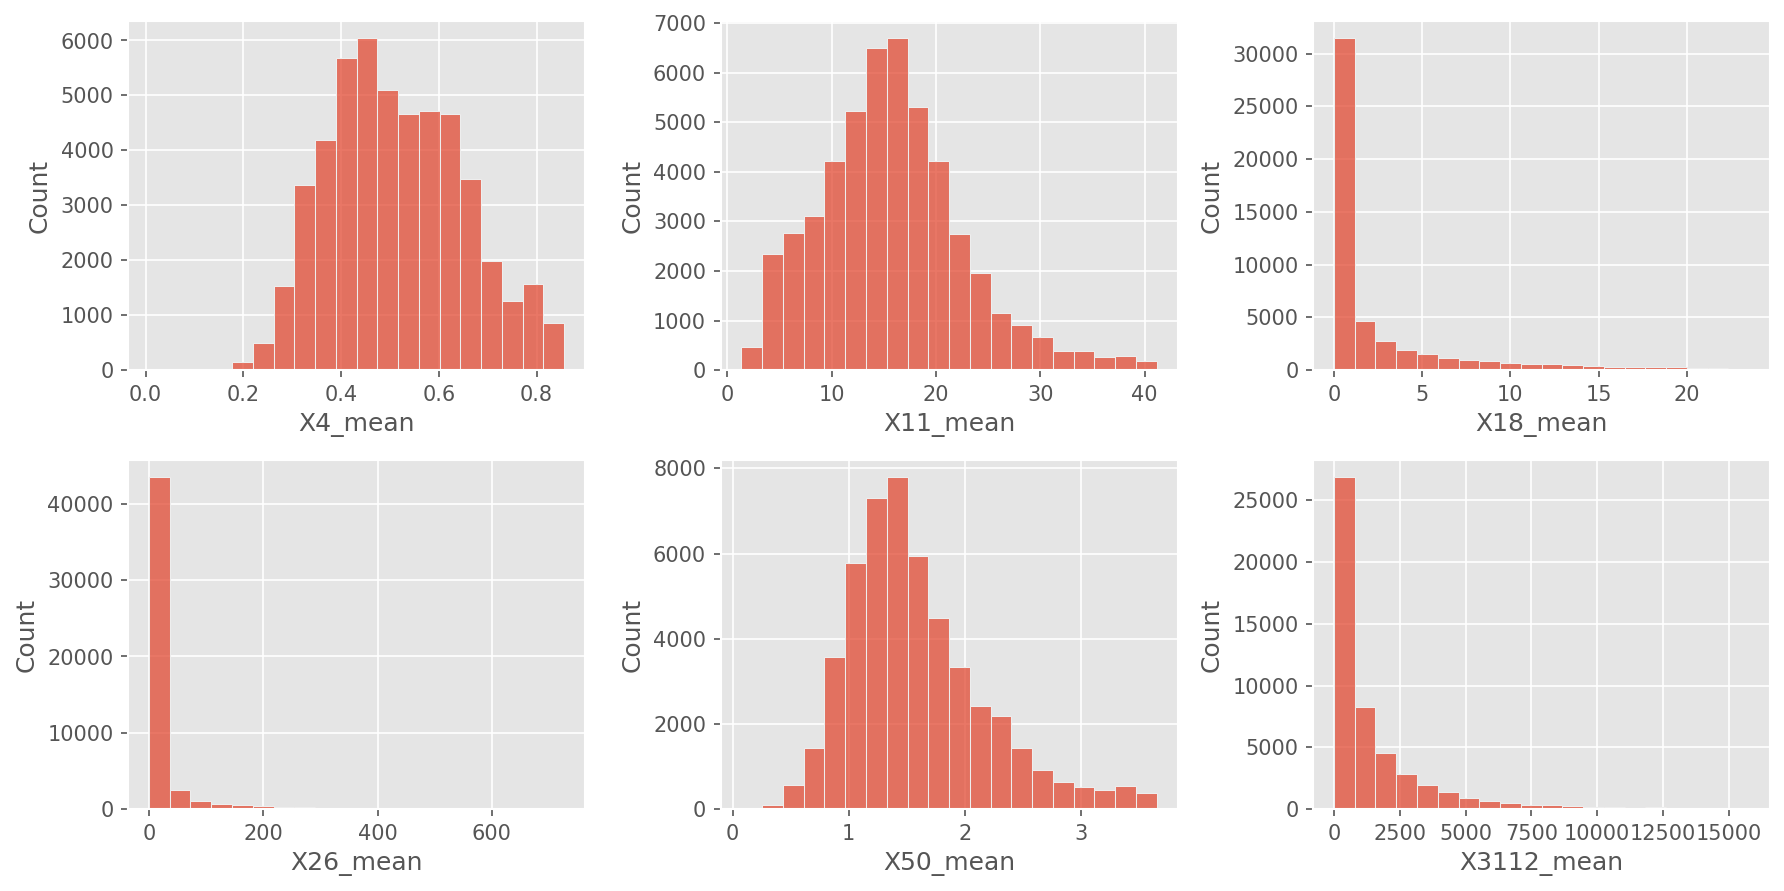

In [7]:
# histograms after filtering out bad observations
n_rows = 2
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
for i, column in enumerate(Y.columns):
    row_idx, col_idx = divmod(i, n_cols)
    _ = sns.histplot(data=Y, x=column, ax=axs[row_idx, col_idx], bins=20)

fig.tight_layout()


In [8]:
# standardize response
output_sc = StandardScaler()
Y_sc = output_sc.fit_transform(Y)

## Image preprocessing functions

In [9]:
def process_image_from_file(file_path:str) -> tf.Tensor:
    # load the image
    img = tf.io.read_file(file_path)
    # decode the jpeg file 
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to 224 x 224 
    img = tf.image.resize(img, [224, 224])
    # preprocessing needed for efficient net
    img = preprocess_input(img)
    return img

# Define your dataset processing function
def process_path(file_path, targets):
    return process_image_from_file(file_path), targets


## Create training and validation sets

In [10]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y_sc, random_state=2, test_size=0.2)

train_ds = tf.data.Dataset.from_tensor_slices((X_train, Y_train.astype(np.float32)))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, Y_val.astype(np.float32)))


# preprocess and batch
train_ds = train_ds.map(process_path).batch(256)
val_ds = val_ds.map(process_path).batch(256)

## Model architecture

In [11]:
keras.backend.clear_session()

# enable mixed precision training 
# keras.config.set_dtype_policy("mixed_float16")


model = keras.Sequential([
    keras.layers.Input(shape = (224, 224, 3), name="input"),
    # augmentation layers
    keras.Sequential([
        keras.layers.RandomRotation(factor=0.1, interpolation='nearest'),
        keras.layers.RandomTranslation(
            height_factor=0.1, width_factor=0.1, interpolation='nearest'
        )
    ], name='augmentation'),
    EfficientNetB0(include_top=False, weights='imagenet', pooling='avg'),
    # output layers
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, name='fc_hidden1'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, name='fc_hidden2'),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(6, name='output')
])

# fix efficientnet weights 
model.get_layer('efficientnetb0').trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss= keras.losses.MeanAbsoluteError(),
    metrics=[keras.metrics.R2Score()]
)

print(model.summary())

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_hidden1 (Dense)              │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_hidden2 (Dense)              │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,412,713 (16.83 MB)

 Trainable params: 362,374 (1.38 MB)

 Non-trainable params: 4,050,339 (15.45 MB)

None


## Training

In [12]:
NUM_EPOCHS= 20
history = model.fit(train_ds, validation_data=val_ds, epochs=NUM_EPOCHS)

Epoch 1/20


2024-04-29 03:16:23.545106: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


156/156 ━━━━━━━━━━━━━━━━━━━━ 139s 785ms/step - loss: 0.7453 - r2_score: -0.1896 - val_loss: 0.5923 - val_r2_score: 0.1380
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 74s 379ms/step - loss: 0.6037 - r2_score: 0.0776 - val_loss: 0.5757 - val_r2_score: 0.1431
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 59s 379ms/step - loss: 0.5845 - r2_score: 0.0999 - val_loss: 0.5707 - val_r2_score: 0.1509
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 59s 379ms/step - loss: 0.5756 - r2_score: 0.1098 - val_loss: 0.5659 - val_r2_score: 0.1533
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 82s 380ms/step - loss: 0.5687 - r2_score: 0.1181 - val_loss: 0.5615 - val_r2_score: 0.1468
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 59s 379ms/step - loss: 0.5640 - r2_score: 0.1274 - val_loss: 0.5591 - val_r2_score: 0.1505
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 59s 379ms/step - loss: 0.5618 - r2_score: 0.1268 - val_loss: 0.5588 - val_r2_score: 0.1540
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 59s 379ms/step - loss: 0.5597 - r2_score: 0.1303 - v

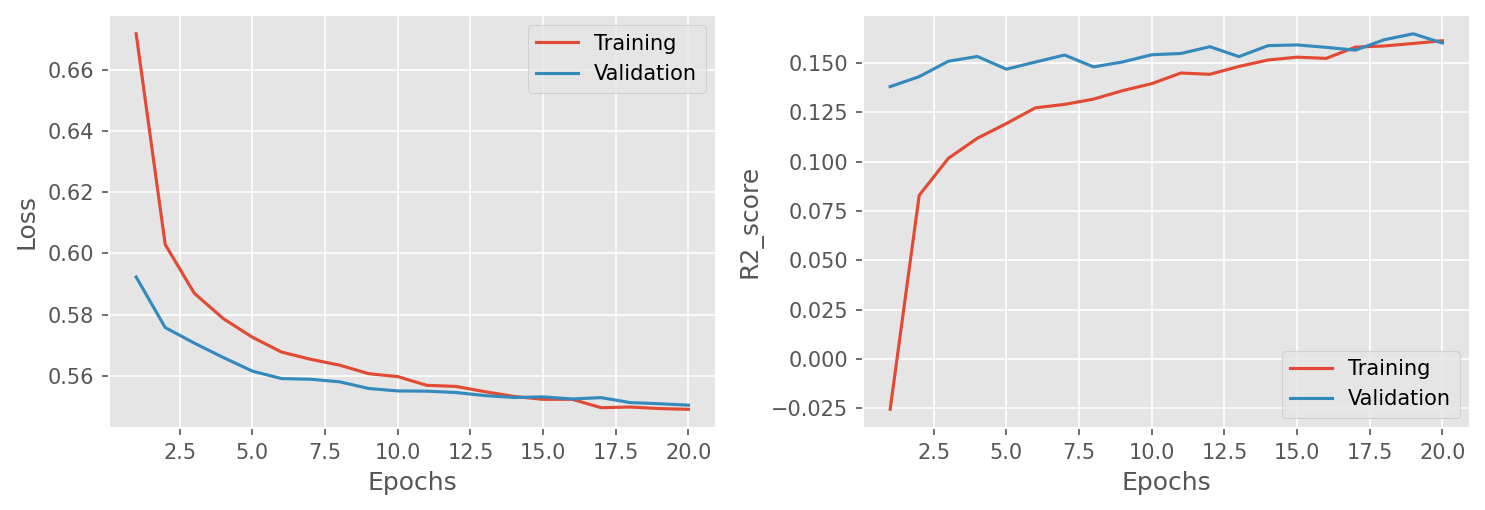

In [13]:
# plot training history
metrics = ['loss','r2_score']

fig,axs = plt.subplots(1,len(metrics),figsize=(5*len(metrics),3.5),dpi=150)

for i,metric in enumerate(metrics):
    
    _ = axs[i].plot(1 + np.arange(NUM_EPOCHS), history.history[f'{metric}'],label='Training')
    _ = axs[i].plot(1 + np.arange(NUM_EPOCHS), history.history[f'val_{metric}'],label='Validation')
    _ = axs[i].legend()
    _ = axs[i].set_ylabel(metric.capitalize())
    _ = axs[i].set_xlabel('Epochs')

fig.tight_layout()
fig.savefig('training_history.png',bbox_inches='tight')
fig.savefig('training_history.pdf',bbox_inches='tight')

In [14]:
# save weights
model.save_weights("model.weights.h5")

## Checking individual output R2

In [15]:
# recreate the validation dataset without the targets
val_ds = tf.data.Dataset.from_tensor_slices((X_val.astype(str),))
val_ds = val_ds.map(process_image_from_file).batch(256)

y_val_pred = model.predict(val_ds)

39/39 ━━━━━━━━━━━━━━━━━━━━ 16s 354ms/step


In [16]:
val_r2_scores = pd.Series(
    r2_score(Y_val, y_val_pred, multioutput='raw_values'),
    index=target_cols,
)
print(val_r2_scores)

X4_mean       0.149740
X11_mean      0.164976
X18_mean      0.363107
X26_mean      0.037004
X50_mean      0.070606
X3112_mean    0.174982
dtype: float64


## Predictions on Test Data

In [17]:
test_ds = tf.data.Dataset.from_tensor_slices((test['img_path'].astype(str).values,))
test_ds = test_ds.map(process_image_from_file).batch(256)
predictions = model.predict(test_ds)

26/26 ━━━━━━━━━━━━━━━━━━━━ 17s 658ms/step


In [18]:
submission = pd.DataFrame(
    output_sc.inverse_transform(predictions),
    columns=targets,
    index=test['id']
).reset_index()


submission.to_csv('submission.csv', index=False)

In [19]:
submission.head()

,id,X4,X11,X18,X26,X50,X3112
0,201238668,0.544999,15.444107,0.451518,1.592902,1.388047,335.100098
1,202310319,0.407941,17.365721,0.472725,1.837573,1.200870,738.681213
2,202604412,0.563911,14.351480,1.015282,4.242839,1.708849,664.511841
3,201353439,0.613301,15.386756,1.589379,4.656121,1.268014,1751.521362
4,195351745,0.470498,13.875067,0.397557,1.659211,1.565631,278.822632
